<a href="https://colab.research.google.com/github/medha130101/Minor_Project/blob/main/FERResnetFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
#from livelossplot import PlotLossesKeras
# from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.7.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Load the Dataset from the ZIP File

In [3]:
!pip install livelossplot

In [4]:
 print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [5]:
! rm -rf train; mkdir train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/emotion.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/facesdb.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/cs230-fer-master/datasets/fer2013/train.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/googlesearch.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/googleset.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/jaffe.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/umea.zip' -d train

In [6]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/cs230 project/cs230-fer-master/datasets/fer2013/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/cs230 project/cs230-fer-master/datasets/fer2013/test-private.zip' -d test

In [25]:
img_size = 48
batch_size = 64

# Data generator to augment data for training
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("/content/train/train", 
                                                    target_size=(img_size,img_size), 
                                                    color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

# Data generator to augment data for validation
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("/content/test/test-private", 
                                                    target_size=(img_size,img_size), 
                                                    color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


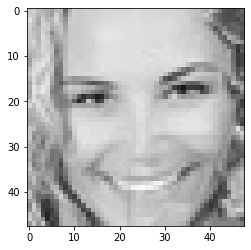

In [26]:
from keras.preprocessing import image
img = image.load_img("/content/test/test-private/happy/PrivateTest_10077120.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [27]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [28]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [29]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [30]:
# Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_4 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 32)                262176    
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                      

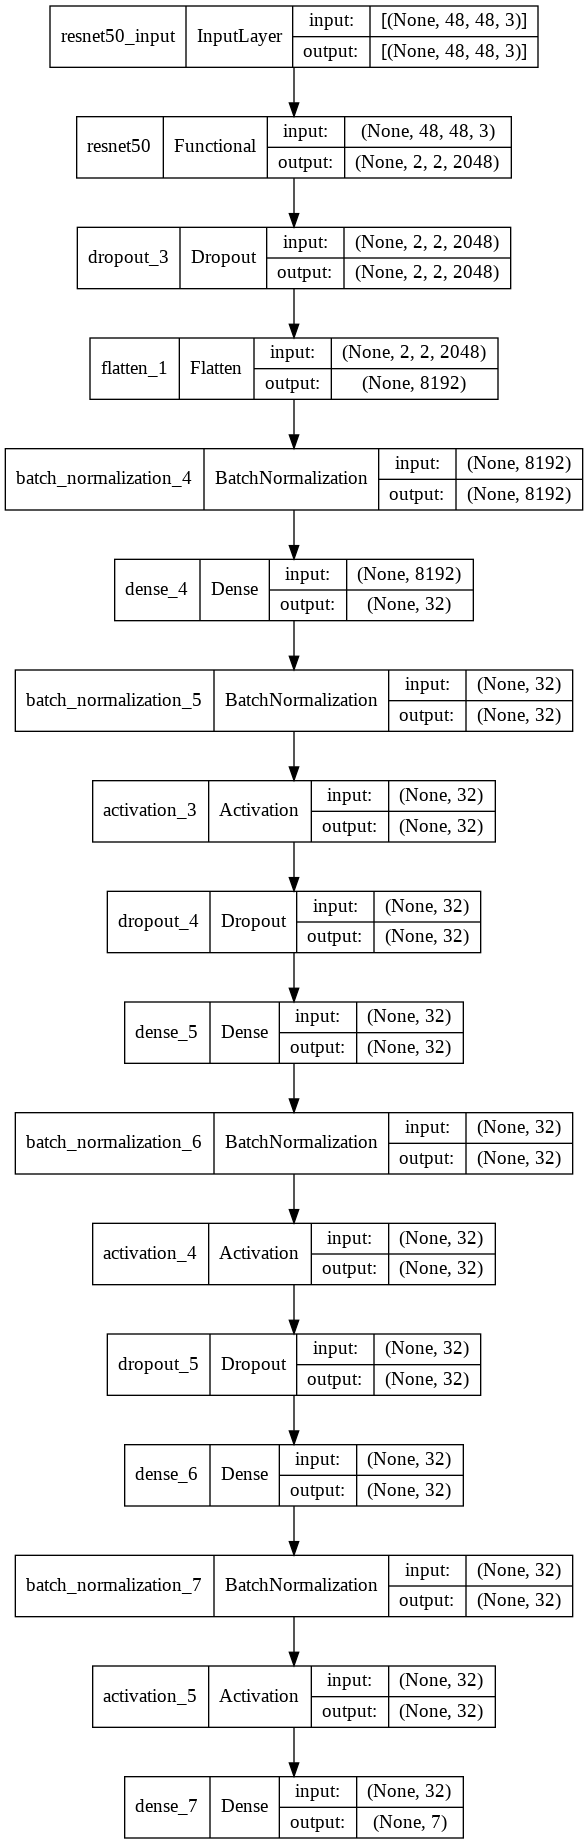

In [31]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [32]:
from livelossplot import PlotLossesKeras
#from livelossplot import PlotLossesTensorFlowKeras
from keras import backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [33]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [35]:
history=model.fit(train_generator,validation_data=validation_generator,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.7945 - accuracy: 0.8568 - precision: 0.4829 - recall: 0.0364 - auc: 0.6752 - f1_score: 0.0668

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


449/449 [==============================] - 58s 98ms/step - loss: 1.7945 - accuracy: 0.8568 - precision: 0.4829 - recall: 0.0364 - auc: 0.6752 - f1_score: 0.0668 - val_loss: 1.6335 - val_accuracy: 0.8614 - val_precision: 0.6779 - val_recall: 0.0563 - val_auc: 0.7594 - val_f1_score: 0.0998 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 41s 91ms/step - loss: 1.6700 - accuracy: 0.8609 - precision: 0.6029 - recall: 0.0776 - auc: 0.7333 - f1_score: 0.1366 - val_loss: 1.5704 - val_accuracy: 0.8651 - val_precision: 0.7174 - val_recall: 0.0919 - val_auc: 0.7796 - val_f1_score: 0.1477 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 40s 90ms/step - loss: 1.6240 - accuracy: 0.8628 - precision: 0.6184 - recall: 0.1026 - auc: 0.7519 - f1_score: 0.1753 - val_loss: 1.5463 - val_accuracy: 0.8682 - val_precision: 0.7070 - val_recall: 0.1318 - val_auc: 0.7859 - val_f1_score: 0.1935 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 41s 91ms/step - lo

In [36]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(validation_generator)
print('test loss, test acc:', results_test)


# Evaluate on test data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


test loss, test acc: [1.4661064147949219, 0.8724676966667175, 0.6767676472663879, 0.20534968376159668, 0.8088864088058472, 0.27543866634368896]


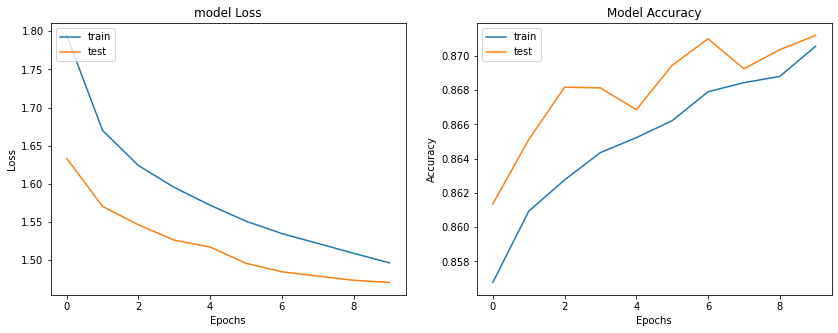

In [38]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion Matrix
[[  86    0  189 1467  691 1060  502]
 [   6    0   32  154   73  124   47]
 [  75    0  190 1471  794 1074  493]
 [ 132    0  349 2659 1327 1851  897]
 [  76    0  229 1813  907 1305  635]
 [  79    0  205 1768  942 1240  596]
 [  60    0  165 1189  563  814  380]]
Classification Report
              precision    recall  f1-score   support

       angry       0.17      0.02      0.04      3995
     disgust       0.00      0.00      0.00       436
        fear       0.14      0.05      0.07      4097
       happy       0.25      0.37      0.30      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.26      0.20      4830
    surprise       0.11      0.12      0.11      3171

    accuracy                           0.19     28709
   macro avg       0.14      0.14      0.13     28709
weighted avg       0.18      0.19      0.17     28709



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


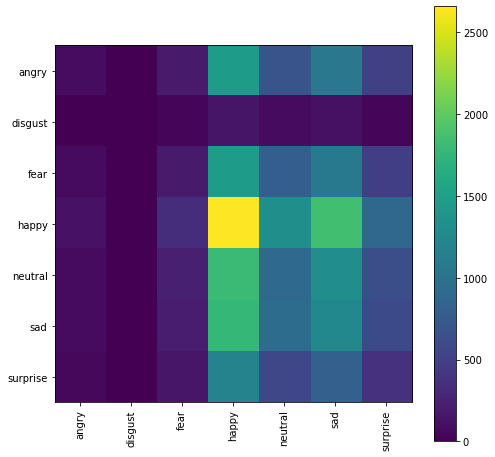

In [39]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[ 16   0  44 153  80 169  29]
 [  3   0   6  15   5  24   2]
 [ 17   0  47 131  74 173  86]
 [  5   0  12 691  64  84  23]
 [  9   0  15 170 270 130  32]
 [  9   0  22 137 110 299  17]
 [  6   0  22  54  47  25 262]]
Classification Report
              precision    recall  f1-score   support

       angry       0.25      0.03      0.06       491
     disgust       0.00      0.00      0.00        55
        fear       0.28      0.09      0.14       528
       happy       0.51      0.79      0.62       879
     neutral       0.42      0.43      0.42       626
         sad       0.33      0.50      0.40       594
    surprise       0.58      0.63      0.60       416

    accuracy                           0.44      3589
   macro avg       0.34      0.35      0.32      3589
weighted avg       0.39      0.44      0.39      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


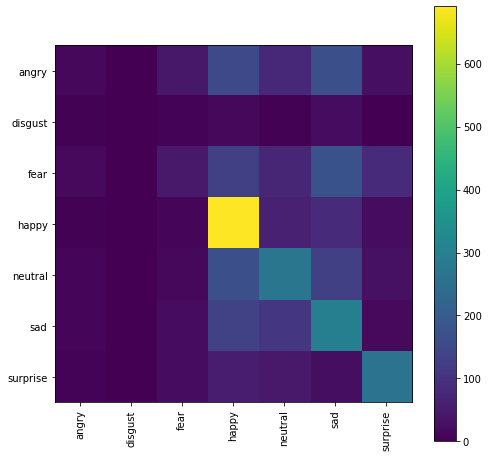

In [40]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

57/57 [==============================] - 4s 74ms/step - loss: 1.4690 - accuracy: 0.8722 - precision: 0.6744 - recall: 0.2037 - auc: 0.8078 - f1_score: 0.2769


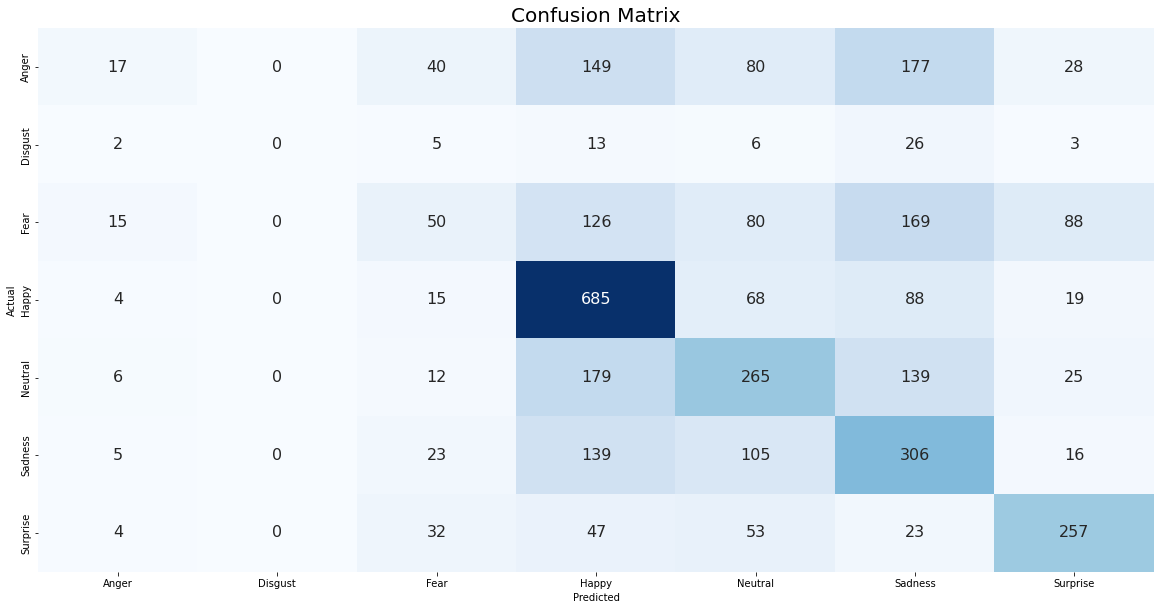

In [41]:
import seaborn as sns
import pandas as pd
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]
model.evaluate(validation_generator)
preds = model.predict(validation_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(validation_generator.labels)
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

ROC AUC score: 0.810283655182731


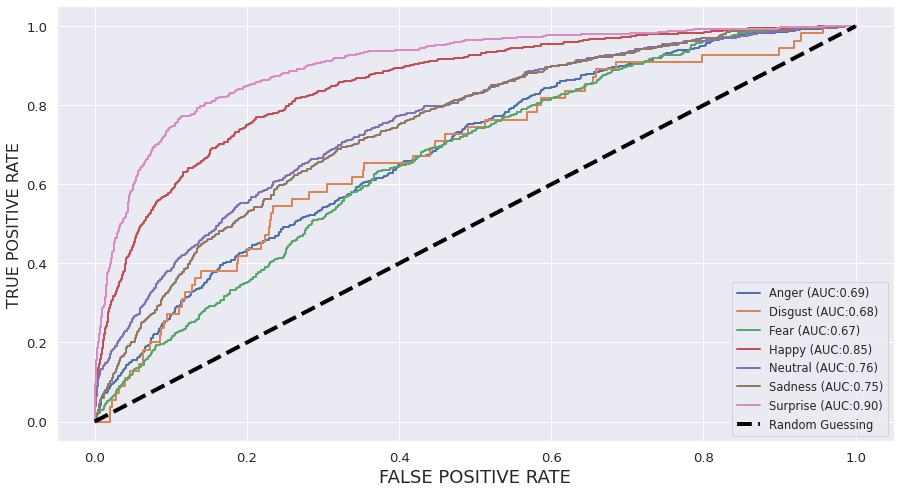

In [45]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()